In [18]:
from qiskit_ibm_runtime import QiskitRuntimeService,SamplerV2 as Sampler
from qiskit import transpile
from qiskit import QuantumCircuit
import qiskit.quantum_info as qi     #to make the custom unitary
import numpy as np
import sympy as sp
from qiskit_aer import AerSimulator   #to simulate the circuit



In [107]:
#Initializations of functions. Do not worry about this. This is just doing the mathematics from the paper and just some shortcuts 
#to get and process data.

service = QiskitRuntimeService(
    channel='ibm_quantum',
    instance='ibm-q/open/main',
    token='372bffac302f0a3c1c1f8ee005fa53f8c7d66ab70e960ab8be23e55ca19a20147fd05a50adf1fd1fe352c93ee46967c82cd0d1b505725717505402f7014c5d53'
)


def get_raw_data(job_id):
    job = service.job(job_id)
    pub_result = job.result()[0]
    return pub_result.data.c.get_counts()

def send_circuit_to_IBM(circuit):
    qc_transpiled = transpile(circuit, backend, optimization_level=3)
    sampler = Sampler(backend=backend)
    qc_job = sampler.run([qc_transpiled], shots=1000)


def transform_bits_to_C4(input_dict):
    transformed_dict = {}
    for key, value in input_dict.items():
        bit_pairs = [key[i:i+2] for i in range(0, len(key), 2)]
        C4_representation = ''.join(str(int(pair, 2)) for pair in bit_pairs)
        transformed_dict[C4_representation] = value
    
    return transformed_dict


#conjugate transpose/adjoint of a matrix
def dagger(matrix):
    return matrix.T.conjugate()

#normalizes vectors
def normalize(vector):
    magnitude_squared = 0
    for component in vector:
        magnitude_squared += component * sp.conjugate(component)
    
    magnitude = sp.sqrt(magnitude_squared)
    normalized_vector = vector / magnitude
    return normalized_vector


def order(pair):
    theta = sp.arg(pair[0])  # Compute argument (phase angle) of the eigenvalue
    if theta < 0:
        theta += 2*sp.pi  # Ensure theta is positive
    return theta

def getz2(n):
    return (sp.exp((sp.I*sp.pi)/(2*n)))**2

A0 = sp.Matrix([[0,0,0,1], [1,0,0,0],[0,1,0,0],[0,0,1,0]])
B0 = sp.Matrix([[0,0,0,1], [1,0,0,0],[0,1,0,0],[0,0,1,0]])
B1 = sp.Matrix([[0,-getz2(4),0,0], [0,0,getz2(4),0],[0,0,0,getz2(4)],[getz2(4),0,0,0]])
A1 = sp.Matrix([[0,0,0,-getz2(4)],[getz2(4),0,0,0],[0,getz2(4),0,0],[0,0,getz2(4),0]])

def get_sorted_normalized_eigenvectors(matrix):
    # Compute eigenvalues and eigenvectors
    eigenvects = matrix.eigenvects()
    
    # Flatten eigenvectors and associate them with their eigenvalues
    eigen_pairs = [(eigenvalue, vect) for eigenvalue, multiplicity, vects in eigenvects for vect in vects]
    
    # Sort eigen_pairs based on the phase angle (theta) of the eigenvalues
    sorted_list = sorted(eigen_pairs, key=order)    
    sorted_eigenvectors = [tup[1] for tup in sorted_list]
    normalized_eigenvectors = []
    
    for vector in sorted_eigenvectors:
        normalized_eigenvectors.append(normalize(vector))
    
    return normalized_eigenvectors
    

#gets unitary based on the order of the eigenvectors input. first eigen vector gets mapped to 0 etc
def get_unitary(ordered_list_of_normalized_eigenvectors):
    dim = len(ordered_list_of_normalized_eigenvectors)
    zero_vector = sp.zeros(dim, 1)
    unitary = sp.zeros(dim, dim)
    for i in range (0,dim):
        zero_vector[i, 0] = 1      #corresponding basis vector
        unitary += zero_vector*dagger(ordered_list_of_normalized_eigenvectors[i])
        zero_vector = sp.zeros(dim, 1)
    
    return unitary 

#gets unitary from any given observable
def get_unitary_from_observable(observable):
    return get_unitary(get_sorted_normalized_eigenvectors(observable))


def convert_mod4_to_Z4(player_output):
    if player_output == 0:
        return 1
    elif player_output == 1:
        return sp.I
    elif player_output == 2:
        return -1
    elif player_output == 3:
        return -sp.I
    
def check_win(x,y,a,b):
    w_n = sp.I
    if x == 0 and y == 0:
        if a == b:
            return 1
    elif x == 0 and y == 1:
        if a * b == 1:
            return 1
    elif x == 1 and y == 0:
        if a == b:
            return 1
    elif x == 1 and y == 1:
        if a * b == w_n:
            return 1
    return 0

#Use this for jobs send to the quantum computer
def process_data(alice_input, bob_input,job_id):  
    total = 0
    for bit_response in transform_bits_to_C4(get_raw_data(job_id)):
            bob_output = int(bit_response[0])  
            alice_output = int(bit_response[-1])
            alice_output_Z4 = convert_mod4_to_Z4(alice_output)
            bob_output_Z4 = convert_mod4_to_Z4(bob_output)
        
            if check_win(alice_input, bob_input, alice_output_Z4,bob_output_Z4 )==1:
                total = total + transform_bits_to_C4(get_raw_data(job_id))[bit_response]
            
    return total/1000


#use this for simulations using Aer
def process_data_from_dict(alice_input, bob_input,results):  
    total = 0
    for bit_response in transform_bits_to_C4(results):
            bob_output = int(bit_response[0])  
            alice_output = int(bit_response[-1])
            alice_output_Z4 = convert_mod4_to_Z4(alice_output)
            bob_output_Z4 = convert_mod4_to_Z4(bob_output)
            
            if check_win(alice_input, bob_input, alice_output_Z4,bob_output_Z4 )==1:
                total = total + transform_bits_to_C4(results)[bit_response]
                
            
    return total/1000




def simulate_circuit(circuit):
    sim = AerSimulator()
    job = sim.run(circuit,shots=1000)
    results = job.result()
    return results.get_counts()
    



In [108]:
#Initialize state and matricies 

A0 = sp.Matrix([[0,0,0,1], [1,0,0,0],[0,1,0,0],[0,0,1,0]])
B0 = sp.Matrix([[0,0,0,1], [1,0,0,0],[0,1,0,0],[0,0,1,0]])
B1 = sp.Matrix([[0,-getz2(4),0,0], [0,0,getz2(4),0],[0,0,0,getz2(4)],[getz2(4),0,0,0]])
A1 = sp.Matrix([[0,0,0,-getz2(4)],[getz2(4),0,0,0],[0,getz2(4),0,0],[0,0,getz2(4),0]])

#These are the observables. Not the unitaries! To get the unitaries from the observables apply the function in the next cell

optimal_state=[0.3801932173932526-0.25403698614397946j,0j,0j,0j,0j,0j,0j,0.3801932173932526+0.25403698614397946j,0j,0j,0.5290046385320097+0.10522556500522232j,0j,0j,0.5290046385320097-0.10522556500522232j,0j,0j]



In [109]:
get_unitary_from_observable(A0)

Matrix([
[ 1/2,  1/2,  1/2, 1/2],
[ I/2, -1/2, -I/2, 1/2],
[-1/2,  1/2, -1/2, 1/2],
[-I/2, -1/2,  I/2, 1/2]])

In [110]:
get_unitary_from_observable(B0)

Matrix([
[ 1/2,  1/2,  1/2, 1/2],
[ I/2, -1/2, -I/2, 1/2],
[-1/2,  1/2, -1/2, 1/2],
[-I/2, -1/2,  I/2, 1/2]])

In [111]:
#Running The Circuits for n=4. All the different circuits are what unitaries Alice and Bob apply given a question pair.

service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=1)

A0_U = qi.Operator(get_unitary_from_observable(A0).tolist())
A1_U = qi.Operator(get_unitary_from_observable(A1).tolist())
B0_U = qi.Operator(get_unitary_from_observable(B0).tolist())
B1_U = qi.Operator(get_unitary_from_observable(B1).tolist())


#Alice and Bob both get 0
qc00 = QuantumCircuit(4,4)
qc00.initialize(optimal_state,[0,1,2,3])
qc00.barrier()
qc00.unitary(A0_U,[0,1],label='A0')
qc00.unitary(B0_U,[2,3],label='B0')
qc00.measure([0,1,2,3],[0,1,2,3])


#Alice gets 0 Bob gets 1
qc01 = QuantumCircuit(4,4)
qc01.initialize(optimal_state,[0,1,2,3])
qc01.barrier()
qc01.unitary(A0_U,[0,1],label='A0')
qc01.unitary(B1_U,[2,3],label='B1')
qc01.measure([0,1,2,3],[0,1,2,3])

#Alice gets 1 Bob gets 0 
qc10 = QuantumCircuit(4,4)
qc10.initialize(optimal_state,[0,1,2,3])
qc10.barrier()
qc10.unitary(A1_U,[0,1],label='A1')
qc10.unitary(B0_U,[2,3],label='B0')
qc10.measure([0,1,2,3],[0,1,2,3])


#Alice gets 1 Bob gets 1 
qc11 = QuantumCircuit(4,4)
qc11.initialize(optimal_state,[0,1,2,3])
qc11.barrier()
qc11.unitary(A1_U,[0,1],label='A1')
qc11.unitary(B1_U,[2,3],label='B1')
qc11.measure([0,1,2,3],[0,1,2,3])


#see send_circuit_to_IBM function to send these circuits indivdually to IBM. To see how well the results did you can use the 
#process_data function that takes the job id as input as well as Alices and Bobs Inputs. The win percent for this game should be around 81%

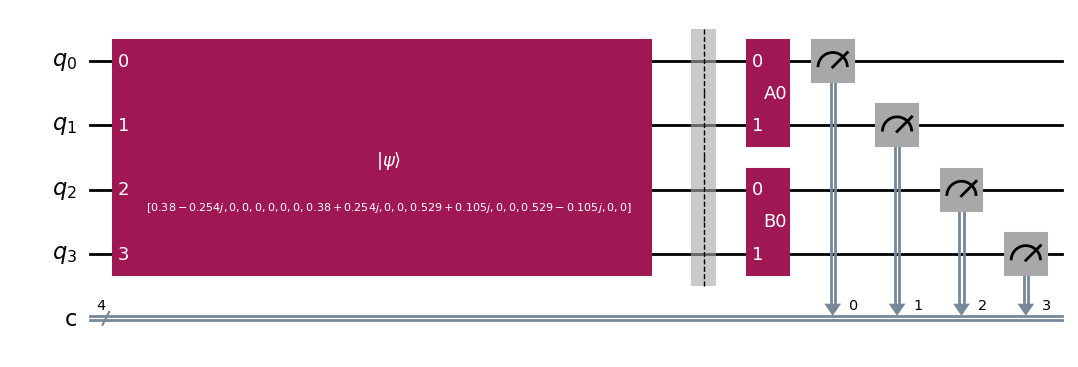

In [112]:
qc00.draw(output='mpl')

In [113]:
process_data_from_dict(1,1,simulate_circuit(qc11))


0.828

In [ ]:
#Notes: amplitude encoding, new transpilers (merge gates),other libraries 